## Семинар 2 "Распознавание рукописных цифр"

ФИО: Сульженко Родион Вадимович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
import torch
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

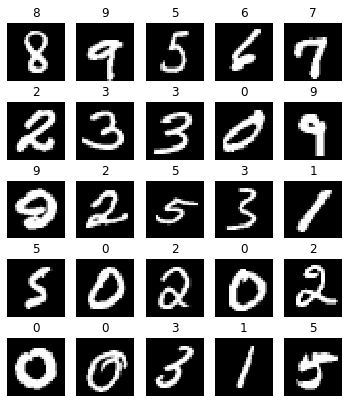

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
def train(network, train_loader1, test_loader1, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader1:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader1:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [6]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(),
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 7... (Train/Test) NLL: 1.320/1.147	Accuracy: 0.538/0.617

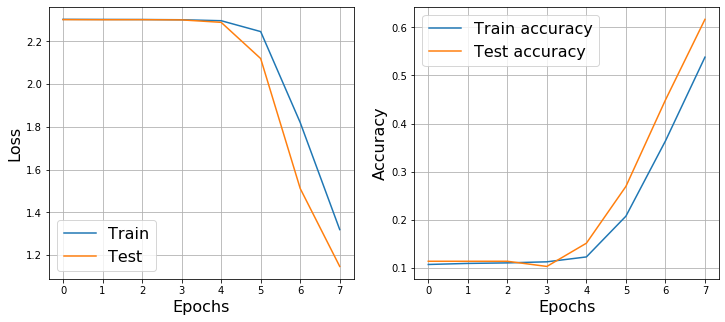

In [7]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, train_loader1=train_loader, 
                                     test_loader1=test_loader,
                                     epochs=8, learning_rate=0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [8]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        # y = max(0, X)
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #dL/dx = dL/dy * dy/dx = dL/dy * (x > 0)
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [9]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        # y = {x if (x > 0); 
        #      alpha * exp(x) - 1 if (x <= 0)}
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        # dL/dx = dL/dy * dy/dx
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy * dydX

    def step(self, learning_rate):
        pass

Epoch 7... (Train/Test) NLL: 0.117/0.118	Accuracy: 0.967/0.966

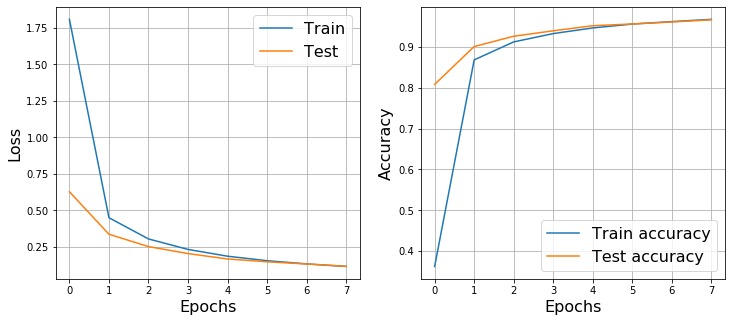

In [10]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, train_loader, test_loader,
                                     epochs=8, learning_rate=0.01,
                                     plot=True, verbose=True)

Epoch 7... (Train/Test) NLL: 0.131/0.130	Accuracy: 0.962/0.962

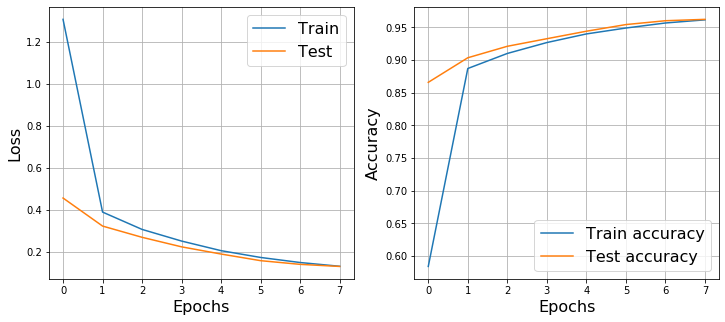

In [11]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, train_loader, test_loader,
                                     epochs=8, learning_rate=0.01,
                                     plot=True, verbose=True)

### HW1 (1 балл): Реализовать Tanh

In [12]:
class Tanh:
    '''
    Tanh(x) = Tanh(x)
    '''
    
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.tanh(X)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        # dL/dx = dL/dy * dy/dx = dL/dy * [sech(X)]^2
        X = self.X
        dydX = 1 / (np.cosh(X)) ** 2
        return dLdy * dydX

    def step(self, learning_rate):
        pass

Epoch 7... (Train/Test) NLL: 0.106/0.112	Accuracy: 0.971/0.966

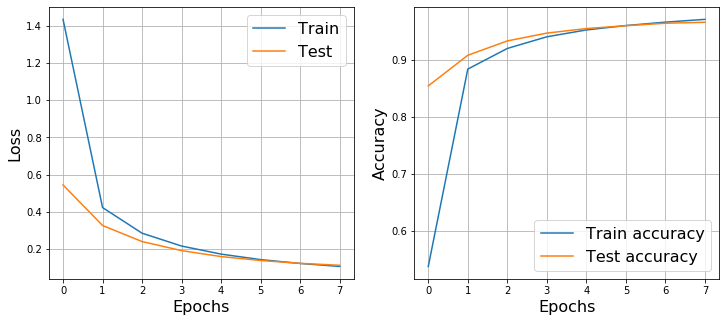

In [13]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, train_loader, test_loader,
                                     epochs=8, learning_rate=0.01,
                                     plot=True, verbose=True)

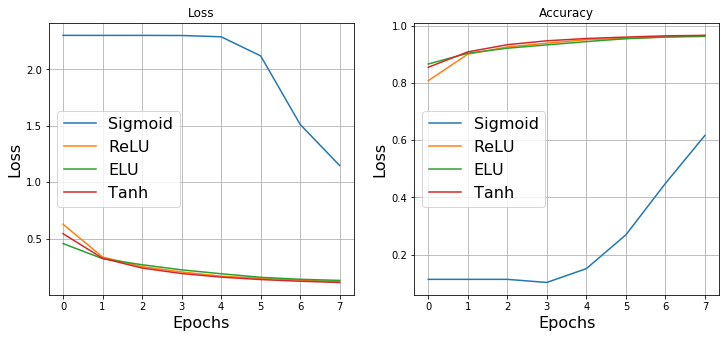

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок

In [15]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

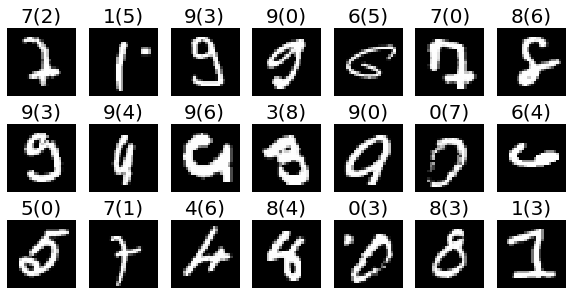

In [16]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [17]:
from torch.utils.data import ConcatDataset

transform_default = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])

def augmentation(custom_transform):
    train_dataset_default = MNIST('.', train=True, download=True, transform=transform_default)
    test_dataset_default = MNIST('.', train=False, transform=transform_default)
    
    train_dataset_transformed = MNIST('.', train=True, download=True, transform=custom_transform)
    
    train_dataset_expanded = ConcatDataset([train_dataset_default, train_dataset_transformed])
    
    train_loader = DataLoader(train_dataset_expanded, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset_default, batch_size=32, shuffle=False)
    
    network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
    loss = NLLLoss()

    return train(network, train_loader, test_loader,
                 epochs=8, learning_rate=0.01, plot=True, verbose=True)
    

##### Покрутим

Epoch 7... (Train/Test) NLL: 0.077/0.079	Accuracy: 0.977/0.977

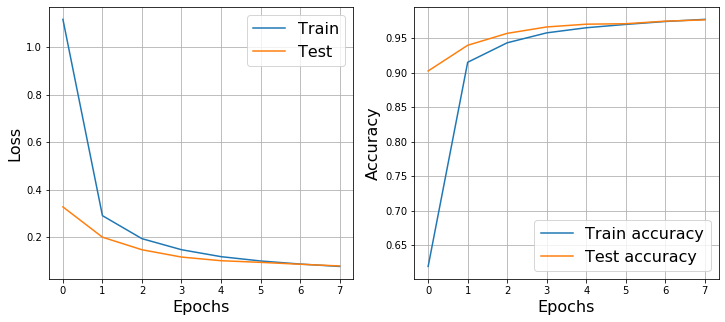

In [18]:
transform_rot = transforms.Compose([
                   transforms.RandomRotation(15, fill=(0,)),
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))])

tr_rot, ts_rot, tr_ac_rot, ts_ac_rot = augmentation(transform_rot)

##### Подвигаем

Epoch 7... (Train/Test) NLL: 0.108/0.067	Accuracy: 0.968/0.979

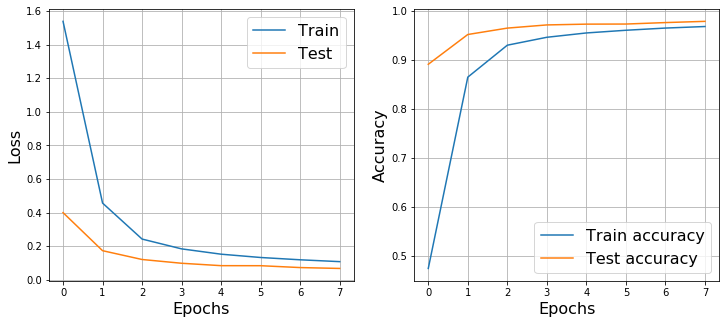

In [19]:
transform_shift = transforms.Compose([
                   transforms.RandomAffine(0, (0.1, 0.1)),
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))])

tr_shift, ts_shift, tr_ac_shift, ts_ac_shift = augmentation(transform_shift)

##### Пошумим

Epoch 7... (Train/Test) NLL: 0.060/0.085	Accuracy: 0.983/0.976

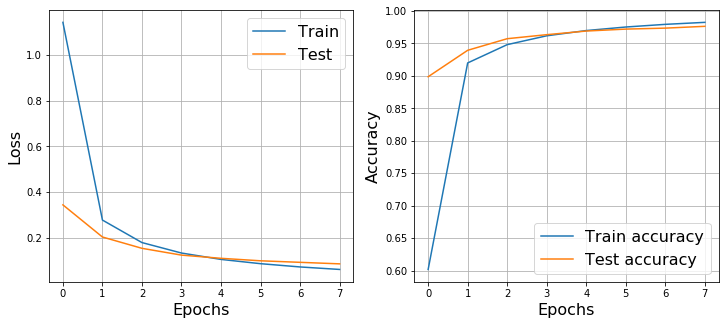

In [20]:
transform_noise = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
                       transforms.Normalize((0.1307,), (0.3081,))])

tr_noise, ts_noise, tr_ac_noise, ts_ac_noise = augmentation(transform_noise)

##### Покрутим+подвигаем+пошумим

Epoch 7... (Train/Test) NLL: 0.134/0.069	Accuracy: 0.960/0.980

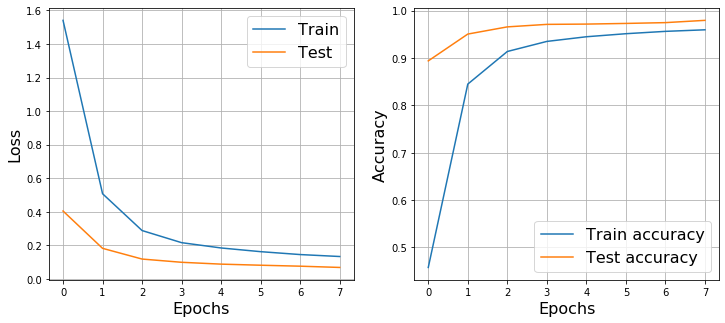

In [21]:
transform_complex = transforms.Compose([
                       transforms.RandomAffine(15, (0.1, 0.1)),
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
                       transforms.Normalize((0.1307,), (0.3081,))])

tr_complex, ts_complex, tr_ac_complex, ts_ac_complex = augmentation(transform_complex)

##### На одном графике:

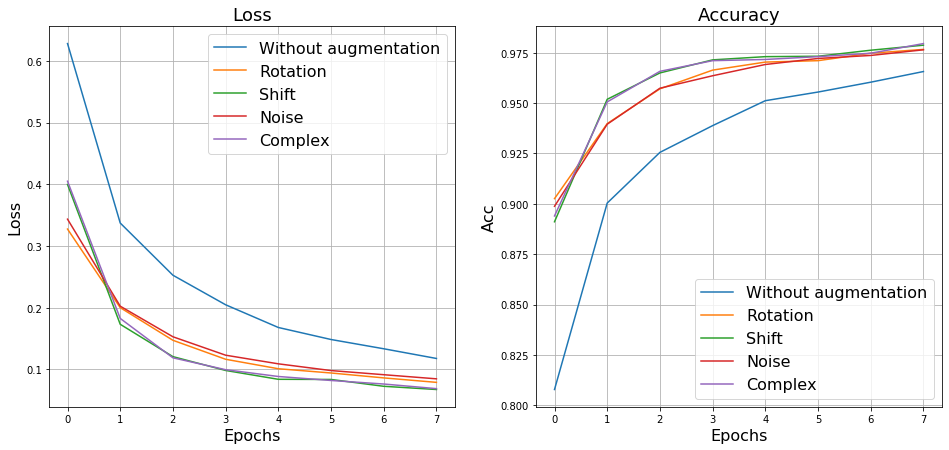

In [22]:
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.title('Loss', fontsize=18)
plt.plot(ts_r[:8], label='Without augmentation')
plt.plot(ts_rot, label='Rotation')
plt.plot(ts_shift, label='Shift')
plt.plot(ts_noise, label='Noise')
plt.plot(ts_complex, label='Complex')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.grid('on')

plt.subplot(1, 2, 2)
plt.title('Accuracy', fontsize=18)
plt.plot(ts_ac_r[:8], label='Without augmentation')
plt.plot(ts_ac_rot, label='Rotation')
plt.plot(ts_ac_shift, label='Shift')
plt.plot(ts_ac_noise, label='Noise')
plt.plot(ts_ac_complex, label='Complex')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Acc', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.grid('on')
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?


- Сигмоида сходится медленне всего. ReLU, ELU, Tanh сходятся примерно одинаково. Разве что, можно сказать, что Tanh сходится чуть быстрее остальных.
- Предобработка данных влияет на сходимость: наибольший прирост дает сдвиг и комплексное применение всех преобразований вместе. 